# ***Сессионное задание*** 
## ***Трек 1. Обучение агента в классической среде***
### ***Цель***
***Продемонстрировать умение применить готовый RL-алгоритм (можно использовать stable-baselines3) для решения стандартной задачи, провести контролируемые эксперименты и проанализировать их влияние на обучение.***

___
***Импортируем необходимые библиотеки, для обучения агентов будем использовать stable_baselines3***

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os
import imageio
from IPython.display import Image as IPImage
from IPython.display import display
from torch import nn
import pandas as pd

___
***Зафиксируем seed***

In [210]:
seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)


___
### ***Для удобства блок с используемыми в проекте функциями и вспомогательными классами вынесен вверх***



___
***Используемые функции для графиков средней награды vs timestep***

***Функция сглаживания - используется для построения графиков, сглаживает массив значений y путем вычисления среднего значения в скользящем окне шириной window.***

In [211]:

def smooth(x, y, window):
    if len(y) >= window:
        y_smooth = np.convolve(y, np.ones(window) / window, mode='valid')
        x_smooth = x[len(x) - len(y_smooth):]
    else:
        y_smooth, x_smooth = y, x
    return  x_smooth, y_smooth

***Функция проверки наличия папки log, данных в ней и выгрузки данных, используется для построения графиков*** 

In [212]:
def check_and_load_logs(log_dir):
    
    if not os.path.exists(log_dir):
        print(f"Папка {log_dir} не найдена.")
        return None, None

    try:
        # Загружаем результаты
        df = load_results(log_dir)

        # Кумулятивные timesteps (сумма длин эпизодов)
        df["timesteps"] = np.cumsum(df["l"])

        # x — timesteps, y — reward
        x = df["timesteps"].values
        y = df["r"].values
    except Exception as e:
        print(f"Ошибка при загрузке логов: {e}")
        return None, None

    if len(y) == 0:
        print("Логи пусты — возможно, обучение ещё не завершено или Monitor не записывал данные.")
        return None, None

    return x, y

***Функция построения графика средней награды vs timestep***

In [213]:
def plot_training_graph(log_dir="./ppo_logs", window=50, model_name="PPO"):
    
    # ================Проверяем наличие логов и загружаем их================
    x, y = check_and_load_logs(log_dir)
    if x is None or y is None:
        return

    # ================Сглаживание================
    x_smooth, y_smooth = smooth(x, y, window)

    # ================Построение графика ================
    plt.figure(figsize=(9, 5))
    plt.plot(x, y, color='gray', alpha=0.3, label='Сырые награды')
    plt.plot(x_smooth, y_smooth, color='crimson', linewidth=2, label=f'Сглажено (окно={window})')
    
    plt.xlabel("Timesteps", fontsize=11)
    plt.ylabel("Средняя награда за эпизод", fontsize=11)
    plt.title(f"Кривая обучения {model_name} на LunarLander-v3", fontsize=13)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.show()

***Функция построения графика средней награды vs timestep для сравнения двух агентов***

In [214]:
def compare_graph(log_dir_first="./a2c_logs", log_dir_second="./ppo_logs", label1="A2C", label2="PPO", window=50):
    
    # ================Проверяем наличие логов и загружаем их для первого агента================
    x_frst, y_frst  = check_and_load_logs(log_dir_first)
    if x_frst is None or y_frst is None:
        return

    # ================Проверяем наличие логов и загружаем их для второго агента================
    x_scnd, y_scnd  = check_and_load_logs(log_dir_second)
    if x_scnd is None or y_scnd is None:
        return
   
    # ======================= Сглаживаем ======================
    x_frst_smooth, y_frst_smooth = smooth(x_frst, y_frst, window)
    x_scnd_smooth, y_scnd_smooth = smooth(x_scnd, y_scnd, window)


    # ============ Строим график сравнения агентов============
    plt.figure(figsize=(10, 6))

    # График для первого
    plt.plot(x_frst, y_frst, alpha=0.4, label=f'{label1} (Сырые награды)')
    plt.plot(x_frst_smooth, y_frst_smooth, color='blue', linewidth=2, label=f'{label1}(Сглаженная)')

    # График для второго
    plt.plot(x_scnd, y_scnd, alpha=0.4, label=f'{label2} (Сырые награды)')
    plt.plot(x_scnd_smooth, y_scnd_smooth, color='red', linewidth=2, label=f'{label2} (Сглаженная)')

    # Оформление графика
    plt.xlabel("Timesteps")
    plt.ylabel("Episode reward")
    plt.title(f"Сравнение средней награды: {label1} vs {label2} (LunarLander-v3)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

___
***Функция построения графика средней награды vs episode для обученной модели***

In [215]:
def plot_reward_vs_episode(log_dir="./ppo_eval_logs", model_name="PPO"):
    """
    Строит график 'Средняя награда vs номер эпизода' из логов Monitor.
    """
    log_file = os.path.join(log_dir, "monitor.csv")
    if not os.path.exists(log_file):
        print(f"Файл логов не найден: {log_file}")
        return
    
    # Загружаем логи Monitor
    data = pd.read_csv(log_file, skiprows=1)  # первая строка — служебная
    rewards = data["r"].values
    episodes = np.arange(1, len(rewards) + 1)

    # Построение графика
    plt.figure(figsize=(9, 5))
    plt.plot(episodes, rewards, color='crimson', label='Награды обученной модели по эпизодам')
      
    plt.xlabel("Номер эпизода", fontsize=11)
    plt.ylabel("Средняя награда за эпизод", fontsize=11)
    plt.title(f"Средняя награда vs Эпизод ({model_name})", fontsize=13)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


***Функция построения графика средней награды vs episode для обученной модели для сравнения двух агентов***

In [216]:
def compare_eval_reward_vs_episode(log_dir_first="./a2c_eval_logs",
                                   log_dir_second="./ppo_eval_logs",
                                   label1="A2C",
                                   label2="PPO"):
    """
    Сравнивает результаты двух обученных агентов по эпизодным наградам
    (данные из monitor.csv в eval_log_dir).
    """
    log_file_1 = os.path.join(log_dir_first, "monitor.csv")
    log_file_2 = os.path.join(log_dir_second, "monitor.csv")

    # Проверяем файлы
    if not os.path.exists(log_file_1):
        print(f"Файл логов не найден: {log_file_1}")
        return
    if not os.path.exists(log_file_2):
        print(f"Файл логов не найден: {log_file_2}")
        return

    # Загружаем данные
    data1 = pd.read_csv(log_file_1, skiprows=1)
    data2 = pd.read_csv(log_file_2, skiprows=1)

    rewards1 = data1["r"].values
    rewards2 = data2["r"].values

    episodes1 = np.arange(1, len(rewards1) + 1)
    episodes2 = np.arange(1, len(rewards2) + 1)

    # Построение графика
    plt.figure(figsize=(9, 5))
    plt.plot(episodes1, rewards1, color='steelblue', label=f'{label1}')
    plt.plot(episodes2, rewards2, color='crimson', label=f'{label2}')

    plt.xlabel("Номер эпизода", fontsize=11)
    plt.ylabel("Средняя награда за эпизод", fontsize=11)
    plt.title(f"Сравнение обученных агентов: {label1} vs {label2}", fontsize=13)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

___
***Функция для сохранения и отображения визуализации***

In [217]:
def record_episode(
    model_path="ppo_lunarlander",
    env_id="LunarLander-v3",
    gif_path="lunarlander_ppo.gif",
    max_steps=10000,
    fps=30,
    deterministic=True,
    show=True
):
  
    # ================Создаём среду с рендером ================
    env = gym.make(env_id, render_mode="rgb_array")

    # ================Загружаем обученную модель================
    model = PPO.load(model_path)

    # ================Запускаем эпизод и собираем кадры ================
    frames = []
    obs, _ = env.reset()
    for step in range(max_steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(action)
        frame = env.render()
        frames.append(frame)
        if terminated or truncated:
            print(f"Эпизод завершён на шаге {step+1}")
            break

    env.close()

    # ================Сохраняем GIF ================
    imageio.mimsave(gif_path, frames, fps=fps)
    print(f"GIF сохранён: {gif_path}")

    # ================Отображаем в ноутбуке ================
    if show:
        display(IPImage(filename=gif_path))

___
***Класс-обёртка для исследование reward-shaping в дальнейшем***

In [218]:
class FuelPenaltyWrapper(gym.Wrapper):
   
    def __init__(self, env, main_engine_penalty=0.3, side_engine_penalty=0.1):
        super().__init__(env)
        self.main_engine_penalty = main_engine_penalty
        self.side_engine_penalty = side_engine_penalty

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        shaped_reward = reward

        # Штраф за использование двигателей
        if action == 3:
            shaped_reward -= self.main_engine_penalty
        elif action in [1, 2]:
            shaped_reward -= self.side_engine_penalty

        return obs, shaped_reward, done, truncated, info

___
### ***1. Выбираем среду LunarLander-v3, так как v2 в gymnasium устарела.***
___
### ***2. Обучим агента с помощью  алгоритма PPO***

*Для этого создаем класс LunarLanderPPOTrainer*

In [ ]:
class LunarLanderPPOTrainer:
    def __init__(self, seed=42, total_timesteps=1_000_000, log_dir="./ppo_logs", eval_log_dir="./ppo_eval_logs",policy_kwargs=dict(net_arch=[256, 256]), shape=False):
        self.seed = seed
        self.total_timesteps = total_timesteps

        # ============ Папки для логов ============
        self.log_dir = log_dir
        self.eval_log_dir = eval_log_dir
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.eval_log_dir, exist_ok=True)

        # ================ Создаём среду LunarLander-v3 ================ 
        env = gym.make("LunarLander-v3")
        if shape:
            env = FuelPenaltyWrapper(env, main_engine_penalty=0.3, side_engine_penalty=0.1) # для будующих экспериментов с reward shaping
        env.reset(seed=seed)
        # для логирования будем использовать Monitor из stable_baselines3
        self.env = Monitor(env, self.log_dir)

        # ================ Инициализируем модель PPO ================
        self.model = PPO(
            "MlpPolicy",
            self.env,
            learning_rate=2.5e-4,      # скорость обучения
            n_steps=1024,            # длина rollout перед обновлением
            batch_size=64,           # размер мини-батча при обучении
            n_epochs=10,             # сколько раз проходить по batch при каждом обновлении
            gamma=0.99,              # коэффициент дисконтирования будущих наград
            gae_lambda=0.95,         # параметр обобщённой оценки преимущества
            clip_range=0.2,          # «граница» изменения политики (регуляризация)
            ent_coef=0.0,            # коэффициент энтропии (поощрение к исследованию)
            vf_coef=0.5,             # вес функции ценности (value loss)
            max_grad_norm=0.5,       # ограничение на норму градиента (устойчивость)
            policy_kwargs=policy_kwargs,  # архитектура сети
            verbose=1,
            seed=self.seed
        )

    # ================Обучаем модель================
    def train(self):
        print("Начинаем обучение модели PPO...")
        start_time = time.time()
        self.model.learn(total_timesteps=self.total_timesteps)
        model_time = time.time() - start_time
        print(f"Обучение завершено за {model_time // 60:.0f} мин {model_time % 60:.1f} сек")

    # ================Сохраняем модель на диск================
    def save(self, path="ppo_lunarlander"):
        self.model.save(path)
        print(f"Модель сохранена в {path}.zip")

    # ================Тестируем обученного агента================
    def evaluate(self, n_eval_episodes=20):
        eval_env = gym.make("LunarLander-v3")
        eval_env = Monitor(eval_env, self.eval_log_dir)
        mean_reward, std_reward = evaluate_policy(self.model, eval_env, n_eval_episodes=n_eval_episodes)

        # Извлекаем длины эпизодов из Monitor
        episode_lengths = eval_env.get_episode_lengths()
        mean_steps = np.mean(episode_lengths)

        
        print(f"Средняя награда по {n_eval_episodes} эпизодам: {mean_reward:.2f} ± {std_reward:.2f}")
        print(f"Среднее количество шагов за эпизод: {mean_steps:.1f}")

*Создадим, обучим и оттестируем нашего агента PPO*

In [220]:
trainer_ppo = LunarLanderPPOTrainer(seed=42, total_timesteps=1_000_000)
trainer_ppo.train()
trainer_ppo.save()
trainer_ppo.evaluate()

Using cpu device
Wrapping the env in a DummyVecEnv.
Начинаем обучение модели PPO...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.8     |
|    ep_rew_mean     | -169     |
| time/              |          |
|    fps             | 1584     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 84.2       |
|    ep_rew_mean          | -153       |
| time/                   |            |
|    fps                  | 962        |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 2048       |
| train/                  |            |
|    approx_kl            | 0.00705609 |
|    clip_fraction        | 0.0539     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.38      |
| 

___
*Для построения графиков создадим функцию*

*Строим график средняя награда/timestep для PPO*

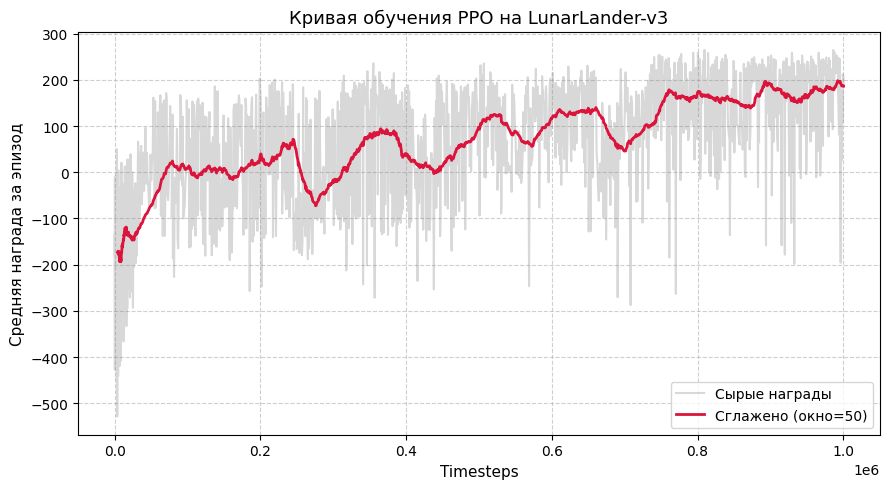

In [221]:
plot_training_graph(log_dir="./ppo_logs")

*График evaluate средняя награда/ Эпизод.*

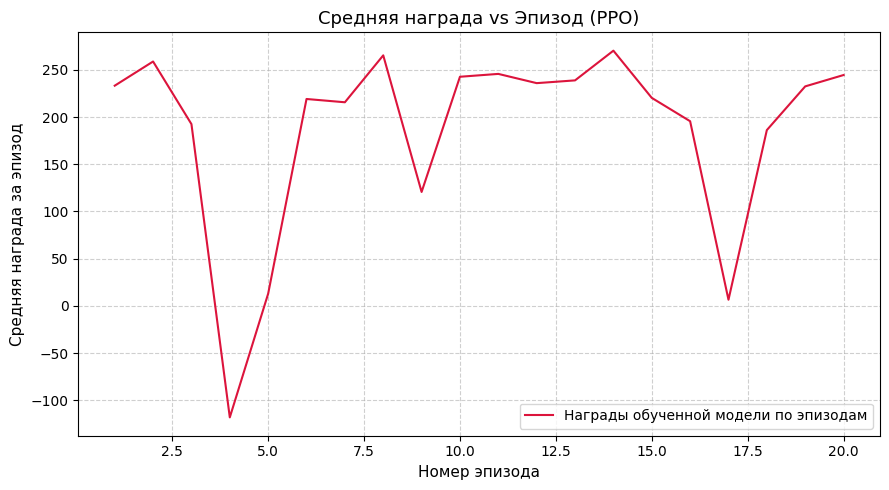

In [222]:
plot_reward_vs_episode(log_dir="./ppo_eval_logs", model_name="PPO")

*Запустим функцию визуализации для PPO*

Эпизод завершён на шаге 426
GIF сохранён: lunarlander_ppo.gif


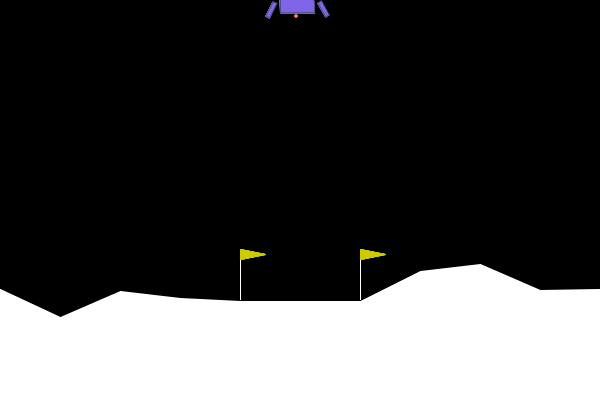

In [223]:
record_episode(
    model_path="ppo_lunarlander",
    env_id="LunarLander-v3",
    gif_path="lunarlander_ppo.gif",
    max_steps=2000,
    fps=30,
    deterministic=True
)

___
### ***3. Проведите два контролируемых эксперимента.***
___
***3.1 Сравнение двух алгоритмов на одной среде.***

*Для сравнения возьмем алгоритм A2C.*

***Гипотеза:*** В среде LunarLander-v3 алгоритм PPO скорее всего покажет себя лучше, чем A2C. Это потому, что PPO обучается более осторожно — он не позволяет политике сильно меняться за один раз, поэтому агент учится стабильнее и делает меньше ошибок. У A2C обновления происходят резче, из-за чего обучение может «скакать» и застревать на плохих решениях.

*Создадим для **A2C** похожий класс*

In [224]:
class LunarLanderA2CTrainer:
    def __init__(self, seed=42, total_timesteps=1_000_000, log_dir="./a2c_logs", eval_log_dir="./a2c_eval_logs",policy_kwargs=dict(net_arch=[256, 256])):
        self.seed = seed
        self.total_timesteps = total_timesteps

        # ============ Папки для логов ============
        self.log_dir = log_dir
        self.eval_log_dir = eval_log_dir
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.eval_log_dir, exist_ok=True)


        # ================ Создаём среду LunarLander-v3 ================ 
        self.env = gym.make("LunarLander-v3")
        self.env.reset(seed=seed)
        self.env = Monitor(self.env, self.log_dir)

        # ================ Инициализируем модель A2C ================
        self.model = A2C(
            "MlpPolicy",
            self.env,
            learning_rate=7e-4,           # скорость обучения
            gamma=0.99,                   # дисконтирование будущих наград
            n_steps=20,                    # шагов до обновления 
            gae_lambda=1.0,               # параметр GAE
            ent_coef=0.01,                 # энтропийный коэффициент (исследование)
            vf_coef=0.5,                  # вес функции ценности
            max_grad_norm=0.5,            # ограничение градиента
            policy_kwargs=dict(net_arch=[256, 256]),  # структура сети
            verbose=1,
            seed=seed
        )

    # ================Обучаем модель================
    def train(self):
        print("Начинаем обучение модели A2C...")
        start_time = time.time()
        self.model.learn(total_timesteps=self.total_timesteps)
        model_time = time.time() - start_time
        print(f"Обучение завершено за {model_time // 60:.0f} мин {model_time % 60:.1f} сек")

    # ================Сохраняем модель на диск================
    def save(self, path="a2c_lunarlander"):
        self.model.save(path)
        print(f"Модель сохранена в {path}.zip")

    # ================Тестируем обученного агента================
    def evaluate(self, n_eval_episodes=20):
        eval_env = gym.make("LunarLander-v3")
        eval_env = Monitor(eval_env, self.eval_log_dir)
        mean_reward, std_reward = evaluate_policy(self.model, eval_env, n_eval_episodes=n_eval_episodes)

        # Извлекаем длины эпизодов из Monitor
        episode_lengths = eval_env.get_episode_lengths()
        mean_steps = np.mean(episode_lengths)

        
        print(f"Средняя награда по {n_eval_episodes} эпизодам: {mean_reward:.2f} ± {std_reward:.2f}")
        print(f"Среднее количество шагов за эпизод: {mean_steps:.1f}")

*Создадим, обучим и оттестируем нашего агента A2C*

In [225]:
trainer_a2c = LunarLanderA2CTrainer(seed=42, total_timesteps=1_000_000)
trainer_a2c.train()
trainer_a2c.save()
trainer_a2c.evaluate()

Using cpu device
Wrapping the env in a DummyVecEnv.
Начинаем обучение модели A2C...
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 107      |
|    ep_rew_mean        | -307     |
| time/                 |          |
|    fps                | 1381     |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.2     |
|    explained_variance | -0.00434 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -47.5    |
|    value_loss         | 1.56e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 129      |
|    ep_rew_mean        | -281     |
| time/                 |          |
|    fps                | 1362     |
|    iterations         | 200      |
|    time_elapsed       | 2 

___
*Строим график A2C*

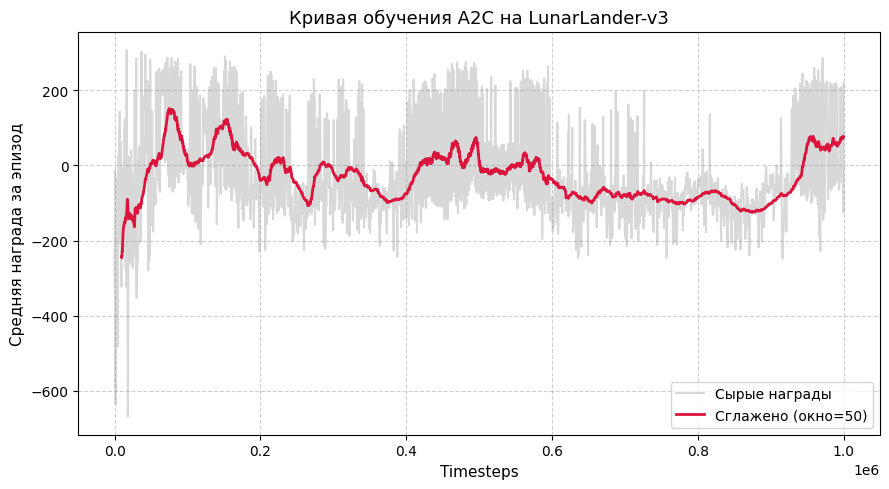

In [226]:
plot_training_graph(log_dir="./a2c_logs", model_name="A2C")

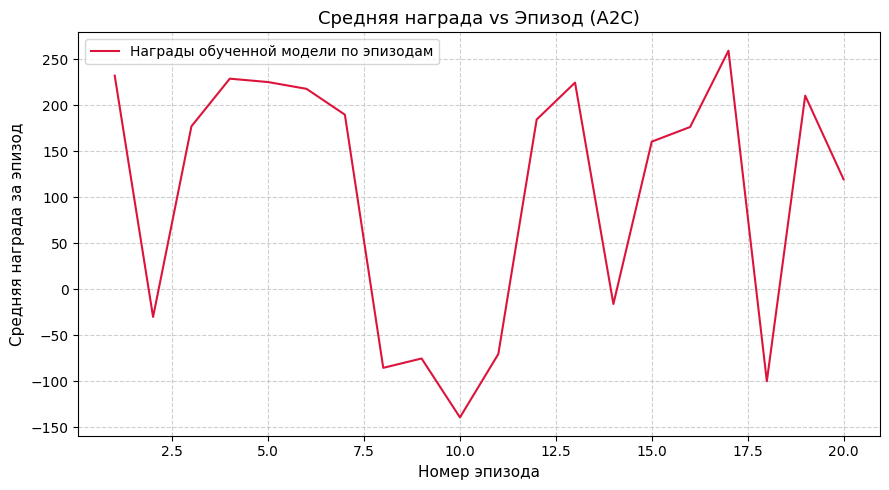

In [227]:
plot_reward_vs_episode(log_dir="./a2c_eval_logs", model_name="A2C")

___
*Запустим функцию визуализации для А2С*

Эпизод завершён на шаге 626
GIF сохранён: lunarlander_a2c.gif


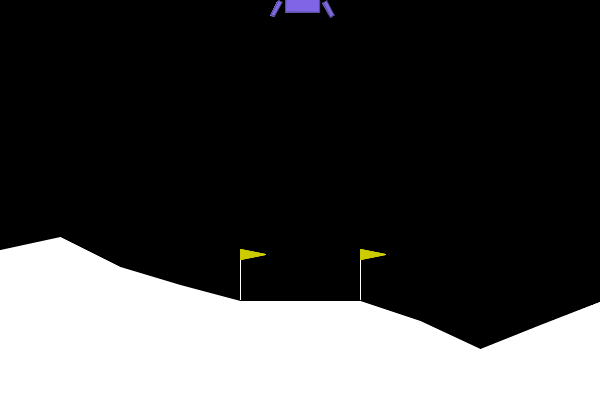

In [228]:
record_episode(
    model_path="a2c_lunarlander",
    env_id="LunarLander-v3",
    gif_path="lunarlander_a2c.gif",
    max_steps=2000,
    fps=30,
    deterministic=True
)

___
*Для более наглядного сравнения отобразим графики средней награды по timestep для двух агентов на одном графике*

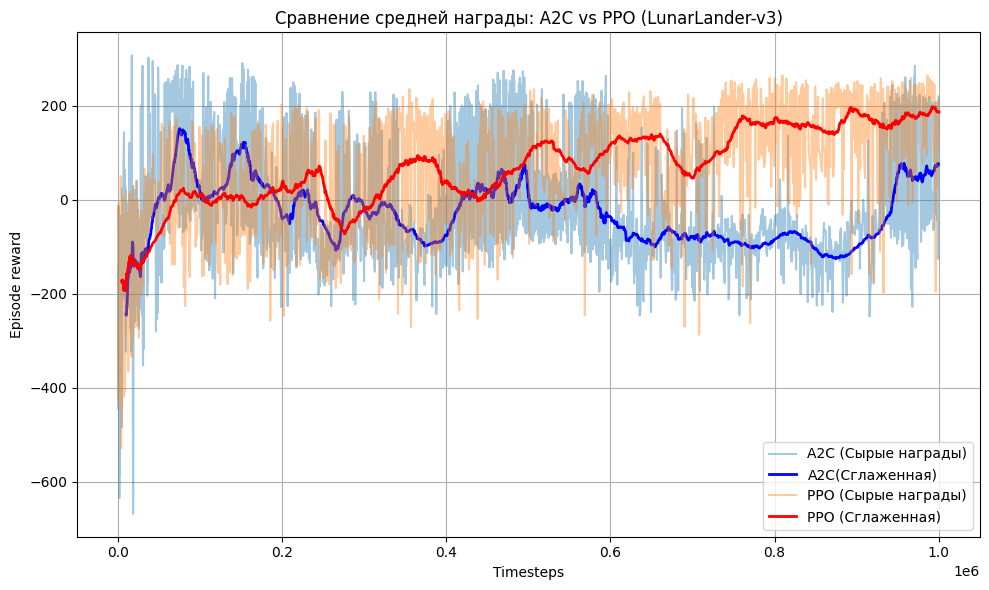

In [229]:
compare_graph()

*Отображаем сравнение наград по эпизодам обученных агентов*

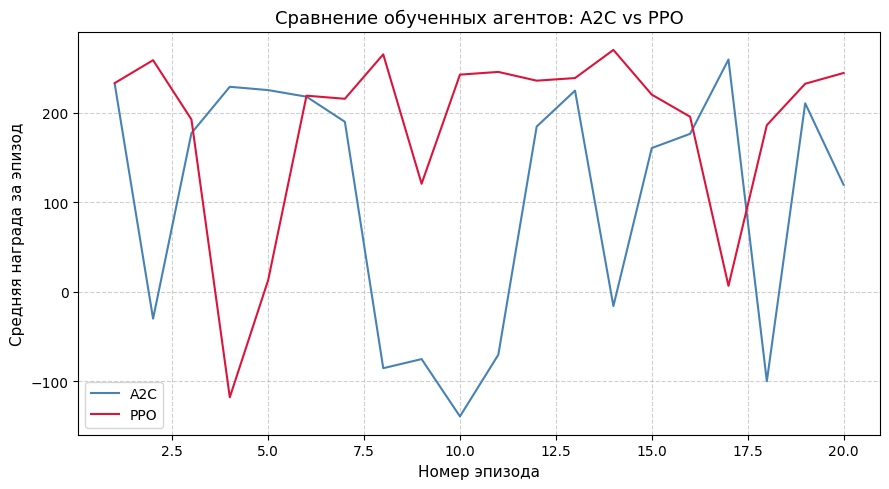

In [230]:
compare_eval_reward_vs_episode(log_dir_first="./a2c_eval_logs",
                                   log_dir_second="./ppo_eval_logs",
                                   label1="A2C",
                                   label2="PPO")

___
***Выводы по пункту 3.1:*** *Результат подтвердил нашу гипотезу. Алгоритм PPO работает стабильнее, разброс средней награды по эпизодам ниже, а сама награда выше. Возможно A2C нужно еще дообучить.*

___
***3.2 Изменение архитектуры нейросети***

***Гипотеза 1:*** *при уменьшени размерности слоев - агент будет обучаться быстрее, но  средняя награда будет ниже.*

***Гипотеза 2:*** *в stable_baselines3 по умолчанию используется функция активации Tanh, при изменении функции активации на Relu обучение будет быстрее, но менее плавным и стабильным.*

 *Проверяем гипотезу 1*

In [231]:
trainer_ppo_1 = LunarLanderPPOTrainer(seed=42,
                                    log_dir="./ppo_logs_experiment_1",
                                    eval_log_dir="./ppo_eval_logs_experiment_1",
                                    policy_kwargs=dict(net_arch=[64, 64]),
                                    total_timesteps=1_000_000)
trainer_ppo_1.train()
trainer_ppo_1.evaluate()

Using cpu device
Wrapping the env in a DummyVecEnv.
Начинаем обучение модели PPO...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93       |
|    ep_rew_mean     | -172     |
| time/              |          |
|    fps             | 1766     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 92.7         |
|    ep_rew_mean          | -170         |
| time/                   |              |
|    fps                  | 1352         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0021356237 |
|    clip_fraction        | 0.00449      |
|    clip_range           | 0.2          |
|    entropy_loss

*Сравним агентов*

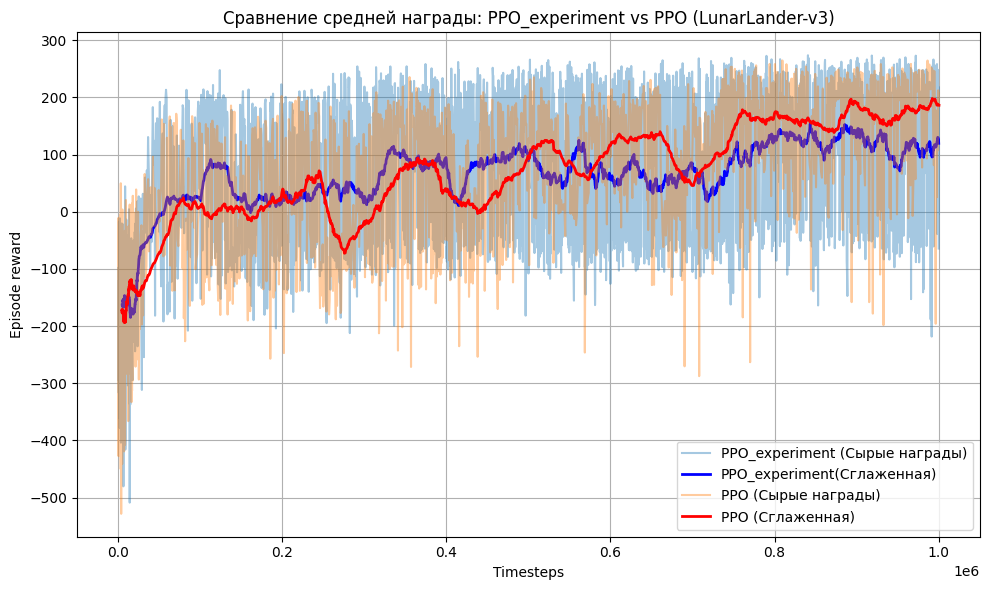

In [232]:
compare_graph(log_dir_first="./ppo_logs_experiment_1", log_dir_second="./ppo_logs", label1="PPO_experiment", label2="PPO")

*Отображаем сравнение наград по эпизодам обученных агентов*

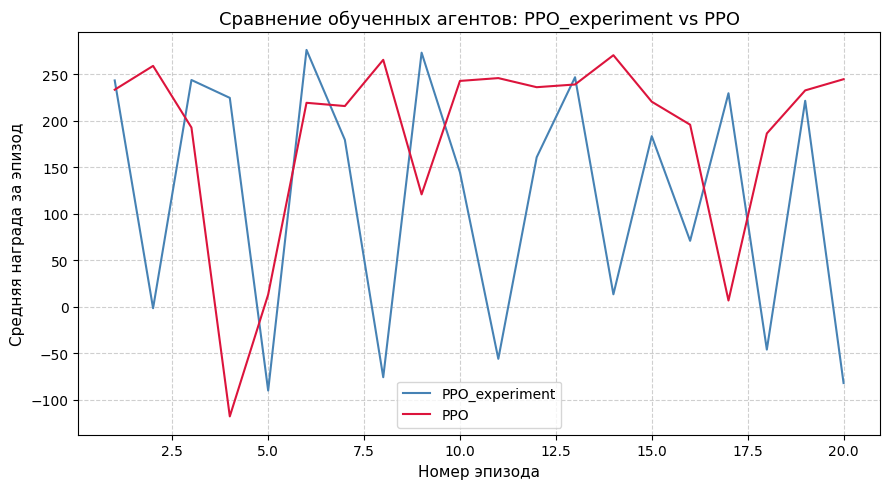

In [233]:
compare_eval_reward_vs_episode(log_dir_first="./ppo_eval_logs_experiment_1",
                                   log_dir_second="./ppo_eval_logs",
                                   label1="PPO_experiment",
                                   label2="PPO")

  ***Гипотеза 1. Вывод:*** *нейросеть с  меньшим количеством нейронов обучилась быстрее, все еще имеет неплохие результаты, но если сравнивать с архитектурой выбранной изначально, то средняя награда к концу обучения ниже и больший разброс наград. Это доказывает что изначально выбранная модель позволяет выучить более сложные зависимости между состояниями и действиями.*

 ___
 *Проверяем **гипотезу 2** - добавляем функцию активации Relu* 

In [234]:
trainer_ppo_2 = LunarLanderPPOTrainer(seed=42,
                                    log_dir="./ppo_logs_experiment_2",
                                    eval_log_dir="./ppo_eval_logs_experiment_2",
                                    policy_kwargs=dict(net_arch=[256, 256],activation_fn=nn.ReLU),
                                    total_timesteps=1_000_000)
trainer_ppo_2.train()
trainer_ppo_2.evaluate()

Using cpu device
Wrapping the env in a DummyVecEnv.
Начинаем обучение модели PPO...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.8     |
|    ep_rew_mean     | -169     |
| time/              |          |
|    fps             | 1901     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 84.3         |
|    ep_rew_mean          | -200         |
| time/                   |              |
|    fps                  | 1242         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0048867706 |
|    clip_fraction        | 0.00879      |
|    clip_range           | 0.2          |
|    entropy_loss

*Сравним агентов*

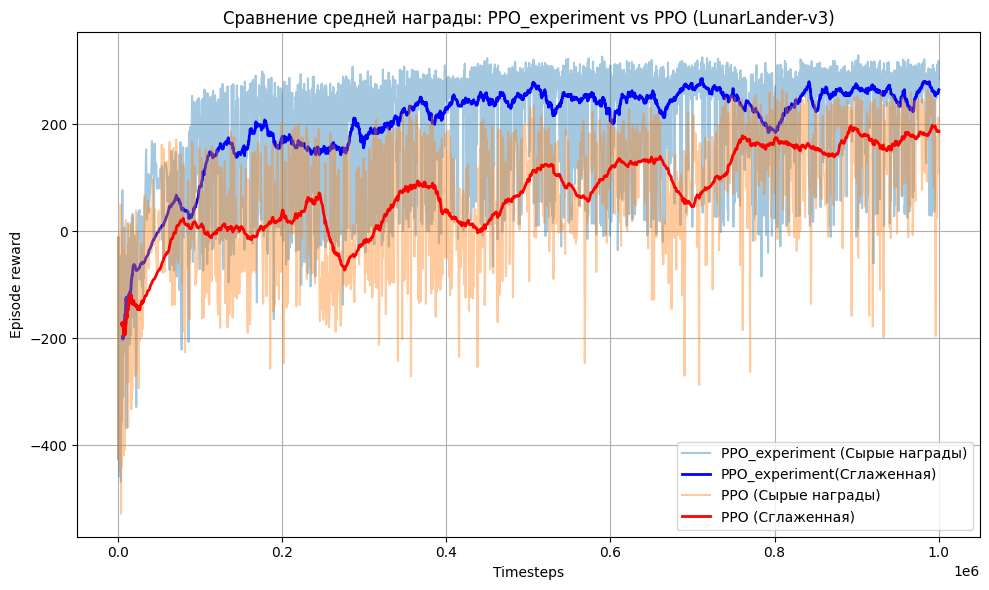

In [235]:
compare_graph(log_dir_first="./ppo_logs_experiment_2", log_dir_second="./ppo_logs", label1="PPO_experiment", label2="PPO")

*Отображаем сравнение наград по эпизодам обученных агентов*

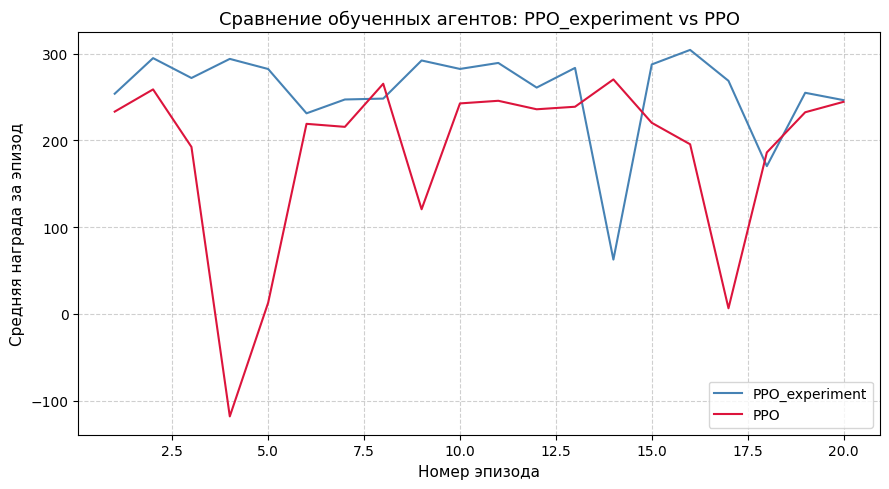

In [236]:
compare_eval_reward_vs_episode(log_dir_first="./ppo_eval_logs_experiment_2",
                                   log_dir_second="./ppo_eval_logs",
                                   label1="PPO_experiment",
                                   label2="PPO")

***Гипотеза 2. Вывод:*** *В опровержение гипотезы обучение агента произошло медленнее, и при этом нейросеть с функцией активации Relu имеет лучшие результаты, это видно изходя из графиков.*

***Выводы по пункту 3.2:*** *Изменния архитектуры нейросети существенно влияет на процесс и результат обучения агента как и в положительную иак и в отрицательную сторону, это подтверждено экспериментально в данном пункте.*

___
***3.3 Reward shaping  для LunarLander***

*Исследуем как добавление штрафов за использование топлива повлияет на нашего агента PPO.*

***Гипотеза:*** *при обучении с штрафами, Агент должен начать чаще экономить топливо соответственно среднее количество шагов для завершения эпизода должно сократиться. Как повлияет это на среднюю награду мне трудно оценить, но я думаю что она должна немного ухудшиться.*

In [237]:
trainer_ppo_3 = LunarLanderPPOTrainer(seed=42,
                                    log_dir="./ppo_logs_experiment_3",
                                    eval_log_dir="./ppo_eval_logs_experiment_3",
                                    policy_kwargs=dict(net_arch=[256, 256]),
                                    total_timesteps=1_000_000,
                                    shape=True)
trainer_ppo_3.train()
trainer_ppo_3.save(path="ppo_lunarlander_shape")
trainer_ppo_3.evaluate()

Using cpu device
Wrapping the env in a DummyVecEnv.
Начинаем обучение модели PPO...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.8     |
|    ep_rew_mean     | -179     |
| time/              |          |
|    fps             | 1586     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 83.5        |
|    ep_rew_mean          | -174        |
| time/                   |             |
|    fps                  | 919         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.006796697 |
|    clip_fraction        | 0.0517      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1

*Сравним агентов*

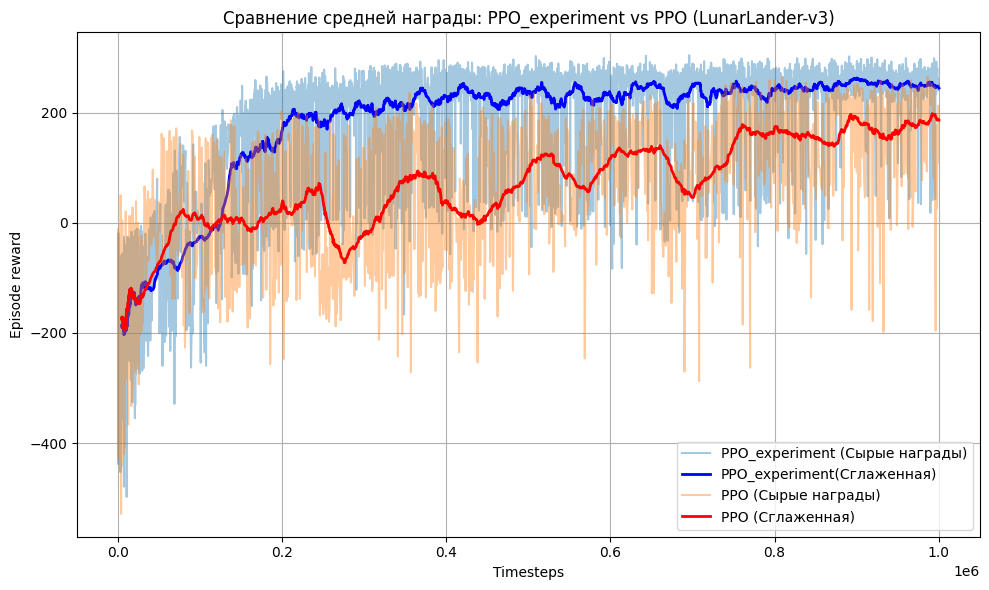

In [238]:
compare_graph(log_dir_first="./ppo_logs_experiment_3", log_dir_second="./ppo_logs", label1="PPO_experiment", label2="PPO")

*Отображаем сравнение наград по эпизодам обученных агентов*

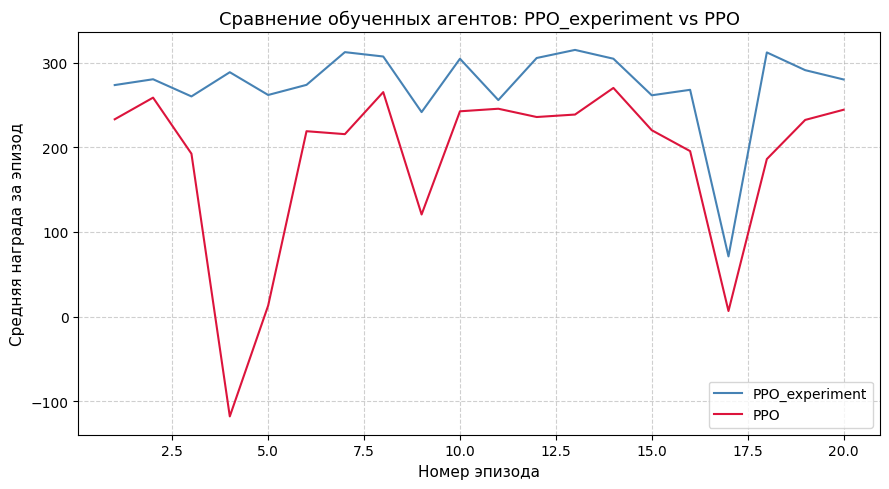

In [239]:
compare_eval_reward_vs_episode(log_dir_first="./ppo_eval_logs_experiment_3",
                                   log_dir_second="./ppo_eval_logs",
                                   label1="PPO_experiment",
                                   label2="PPO")

Эпизод завершён на шаге 234
GIF сохранён: lunarlander_ppo_shape.gif


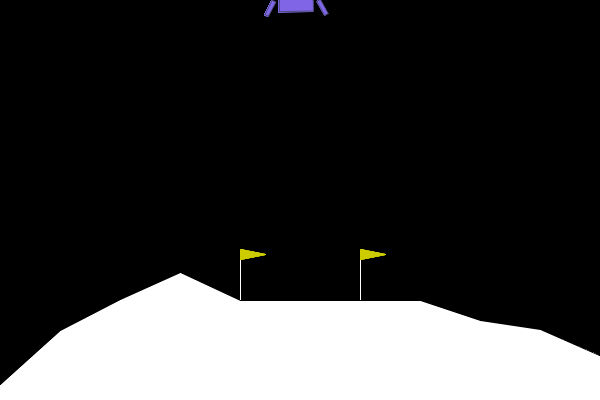

In [242]:
record_episode(
    model_path="ppo_lunarlander_shape",
    env_id="LunarLander-v3",
    gif_path="lunarlander_ppo_shape.gif",
    max_steps=2000,
    fps=30,
    deterministic=True
)

 ***Вывод: Reward Shaping*** *значительно улучшил результаты, мы видим что агент учится стабильнее, разброс наград сильно меньше на всем периоде обучения,а сама награда значительно выше. Количество шагов на эпизод так же сократилось более чем в 2 раза, как я и предполагал. Это лучший агент из всех тестируемых.* 

___
## ***Общие выводы по работе:***

В данной работе:
- 1) Была выбрана среда для изучения LunarLander-v3.
- 2) C помощью библиотеки stable_baselines3 был обучен агент PPO.
- 3) Были проведены 3 эксперимента:
    - Сравнение моделей PPO и A2C;
    - Изучение влияния архитектуры нейросети на обучение и результат агента PPO;
    - Влияние Reward shaping - добавление штрафа за использование топлива в LunarLander на обучение и результат агента PPO.

- Лучший агент по результатом экспериментов - PPO с Reward shaping.
- Для всех моделей построены графики  средней награды vs timestep/episode.
- Созданы Gif анимации для агентов PPO, A2C и PPO с Reward shaping.
- Произведена оценка для всех агентов - средняя награда по 20 эпизодам, cреднее количество шагов на эпизод.
- Зафиксирован seed  код воспроизводим. Графики всегда получаются идентичные.


In [241]:
!pip freeze > requirements.txt